# 5.13　专题：核密度估计

高斯混合模型（GMM）——一个聚类和密度评估器的混合体。密度评估器是一种利用 D 维数据集生成 D 维概率分布估计的算法。GMM 算法用不同
高斯分布的加权汇总来表示概率分布估计。核密度估计（kernel density estimation，KDE）
算法将高斯混合理念扩展到了逻辑极限（logical extreme）。它通过对每个点生成高斯分布
的混合成分，获得本质上是无参数的密度评估器。

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

D:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


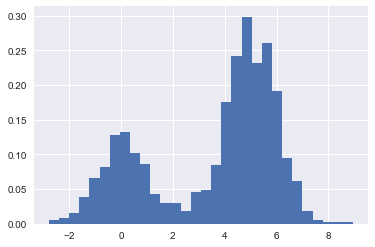

In [10]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x
x = make_data(1000)
hist = plt.hist(x, bins=30, normed=True)

In [11]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

D:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


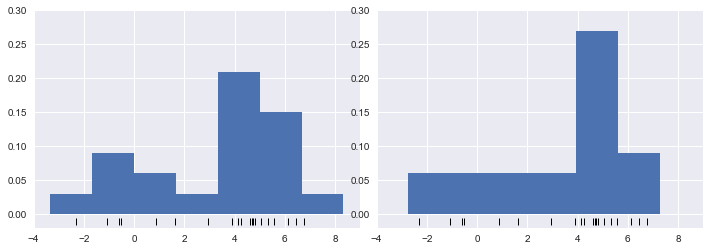

In [15]:
x = make_data(20)
bins = np.linspace(-5,10,10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                      subplot_kw={'xlim':(-4, 9),
                                  'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

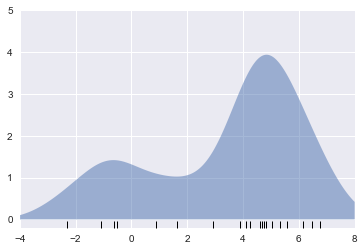

In [16]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 5]);

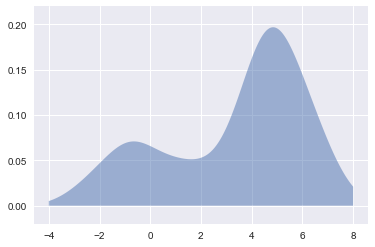

In [18]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:,None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:,None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22);

使用 Scikit-Learn 的标准网格搜索工具。
这里用 GridSearchCV 来优化前面数据集的密度估计带宽。因为我们要处理的数据集规模
比较小，所以使用留一法进行交叉检验，该方法在每一次做交叉检验时，都会最小化训
练集的损失：

In [19]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

bandwidth = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidth},
                    cv=LeaveOneOut(len(x)))
grid.fit(x[:, None]);

In [21]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

## 示例：球形空间的KDE

In [22]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# 获取物种ID和位置矩阵/数组
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

In [25]:
"""from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[: 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);"""

"from mpl_toolkits.basemap import Basemap\nfrom sklearn.datasets.species_distributions import construct_grids\n\nxgrid, ygrid = construct_grids(data)\n\nm = Basemap(projection='cyl', resolution='c',\n            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),\n            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())\nm.drawmapboundary(fill_color='#DDEEFF')\nm.fillcontinents(color='#FFEEDD')\nm.drawcoastlines(color='gray', zorder=2)\nm.drawcountries(color='gray', zorder=2)\n\n# plot locations\nm.scatter(latlon[:, 1], latlon[: 0], zorder=3,\n          c=species, cmap='rainbow', latlon=True);"

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """基于KDE的贝叶斯生成分类器
    
    Parameters
    -----------
    bandwidth : float
        the kernrl bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity 
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        '''
        除了将参数值传递给
        self 之外，初始化不包含任何操作。
        '''
        self.bandwidth = bandwidth
        self.kernel = kernel
    
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y)) # 首先在训练数据集中找到所有类（对标签去重）
        training_sets = [X[y == yi] for yi in self.classes_]
        # 为每一类训练一个 KernelDensity 模型
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        # 根据输入样本的数量计算类的先验概率
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
    
    def predict_prob(self, X):
        '''
        它返回的是每个类概率的数组，数组的形状为 [n_samples, n_classes]。
        这个数组中的 [i, j] 表示样本 i 属于 j 类的后验概率，
        用似然估计先乘以类先验概率，再进行归一化。
        '''
        logprob = np.array([model.score_samples(X)
                            for model in self.models_]).T
        result = np.exp(logprob + self.logpriors_)
        return result / result.sum(1, keepdims=True)
    
    def predict(self, X):
        '''
        根据这些概率，返回概率值最大的类。
        '''
        return self.classes_[np.argmax(self.predict_prob(X), 1)]

In [27]:
from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(),{'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.grid_scores_]

{'bandwidth': 7.054802310718643}
accuracy =  0.9666110183639399


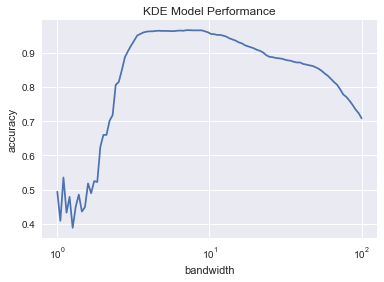

In [29]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy = ', grid.best_score_)

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8186003803550138